## Imports

In [62]:
from data.Data import Data

from models.NaiveBayes import NaiveBayes
from models.RandomModel import RandomModel
from models.NeuralNetwork import NeuralNetwork
from models.XGBoost import XGBoost
from models.RandomForest import RandomForest
from models.SupportVectorMachine import SupportVectorMachine

from model_evaluator.ModelEvaluator import ModelEvaluator

import random
import pandas as pd
import numpy as np
import os
import time

from matplotlib import pyplot as plt
from math import ceil

# Seed

In [78]:
seed = None
if not seed:
    seed = random.randint(0, 99999)
print(f"SEED: {seed}")

np.random.seed(seed=seed)
random.seed(seed)

SEED: 43346


## Cutoff for ROC calculation

In [64]:
CUTOFFS = np.arange(0, 1, 0.02)

## Data

In [65]:
dataset = "breast-cancer"
COLUMNS_FOR_BREAST_CANCER = ['node-caps', 'inv-nodes', 'tumor-size', 'deg-malig', 'irradiat', 'class']

distinct_columns = None
if dataset == "breast-cancer":
  distinct_columns = COLUMNS_FOR_BREAST_CANCER

data = Data(dataset, distinct_columns=distinct_columns)

train, eval = data.get_train_and_valid_set(0.7)

train_x = train.drop('class', axis=1)
train_y = train['class']

eval_x = eval.drop('class', axis=1)
eval_y = eval['class']

# Check class disproportion

In [66]:
print(f"train_0: {len(train[train['class'] == 0])}, train_1: {len(train[train['class'] == 1])}")
print(f"test_0: {len(eval[eval['class'] == 0])}, test_1: {len(eval[eval['class'] == 1])}")

train_0: 140, train_1: 60
test_0: 61, test_1: 25


## Models

In [67]:
MODELS_DIR = "./model_saves"

nn_models_dir = os.path.join(MODELS_DIR, "nn_models_saves")
xgb_models_dir = os.path.join(MODELS_DIR, "xgb_models_saves")

In [68]:
models = [
    RandomModel(),
    NaiveBayes(),
    NeuralNetwork(len(train_x.columns), os.path.join(nn_models_dir, f"model_{dataset}.pt")),
    RandomForest(),
    XGBoost(os.path.join(xgb_models_dir, f"model_{dataset}.json")),
    SupportVectorMachine()
]

[10:27:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


## Train models

In [69]:
exec_times = {}
for model in models:
    start = time.time()
    model.fit(train_x, train_y)
    end = time.time()
    exec_times[model.name] = end - start


## Calculate models metrics

In [70]:
model_evals = {
   model.name: ModelEvaluator(model) for model in models
}

In [71]:
for name, model_eval in model_evals.items():
    model_eval.calculate_quality(eval_x, np.array(eval_y))

## Results

In [72]:
for name, model_eval in model_evals.items():
    print(model_eval)

BinaryClassificationModel: RandomModel
Confusion Matrix: 
[[11 31]
 [14 30]]
Accuracy: 0.47674418604651164
Recall(also known as Sensitivity): 0.44
Specificity: 0.4918032786885246
Precision: 0.2619047619047619
F1 Score: 0.3283582089552239
Support: 25

BinaryClassificationModel: NaiveBayes
Confusion Matrix: 
[[11 10]
 [14 51]]
Accuracy: 0.7209302325581395
Recall(also known as Sensitivity): 0.44
Specificity: 0.8360655737704918
Precision: 0.5238095238095238
F1 Score: 0.4782608695652174
Support: 25

BinaryClassificationModel: NeuralNetwork
Confusion Matrix: 
[[18  7]
 [ 7 54]]
Accuracy: 0.8372093023255814
Recall(also known as Sensitivity): 0.72
Specificity: 0.8852459016393442
Precision: 0.72
F1 Score: 0.72
Support: 25

BinaryClassificationModel: RandomForest
Confusion Matrix: 
[[11  9]
 [14 52]]
Accuracy: 0.7325581395348837
Recall(also known as Sensitivity): 0.44
Specificity: 0.8524590163934426
Precision: 0.55
F1 Score: 0.48888888888888893
Support: 25

BinaryClassificationModel: XGBoost
Con

## Results

### ROC curves

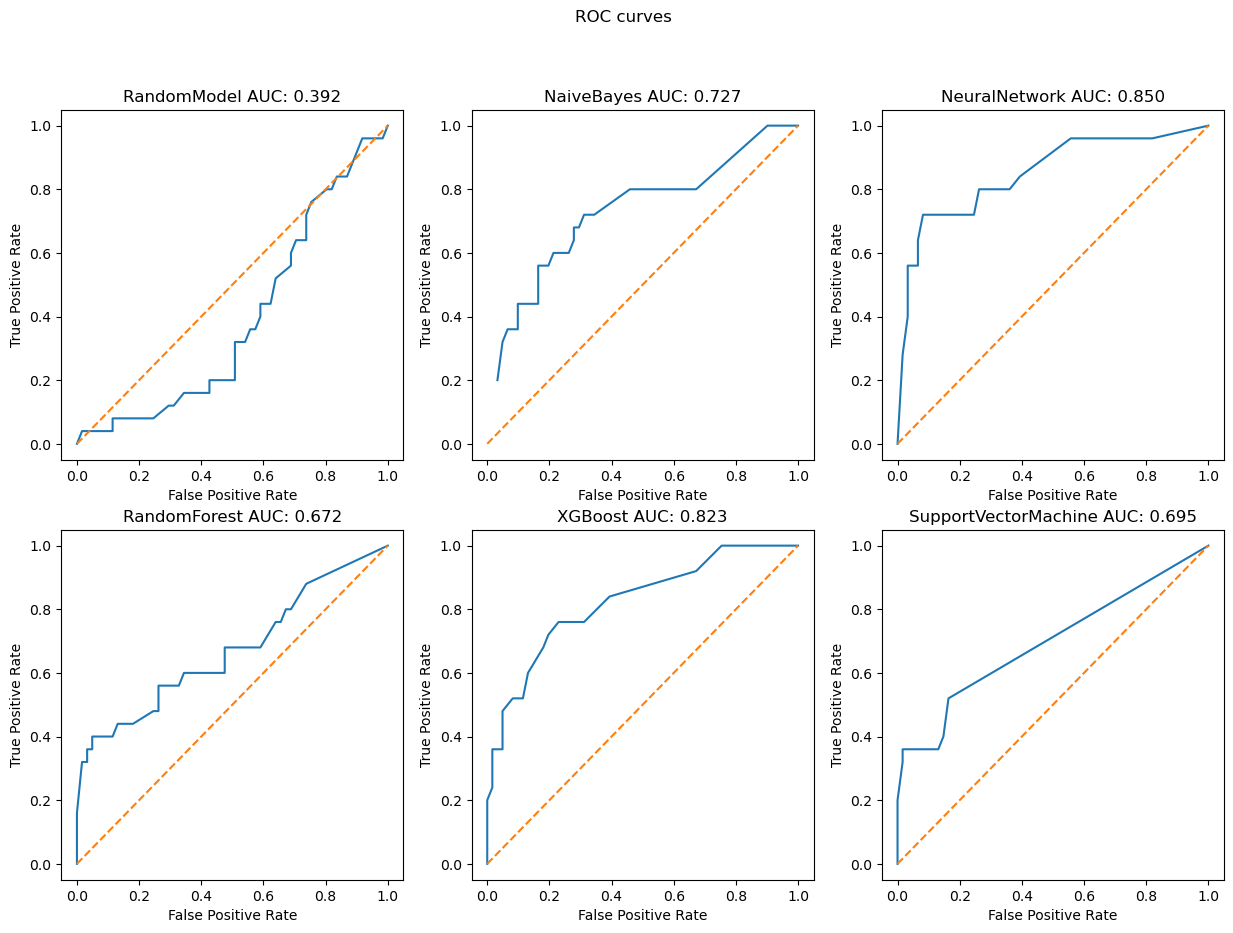

In [73]:
fig, axs = plt.subplots(2, ceil(len(models)/2))
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('ROC curves')
for model_eval, ax in zip(model_evals.values(), axs.flatten()):
    model_eval.plot_roc_curve(ax, eval_x, np.array(eval_y), CUTOFFS)
plt.show()

# Confusion matrices

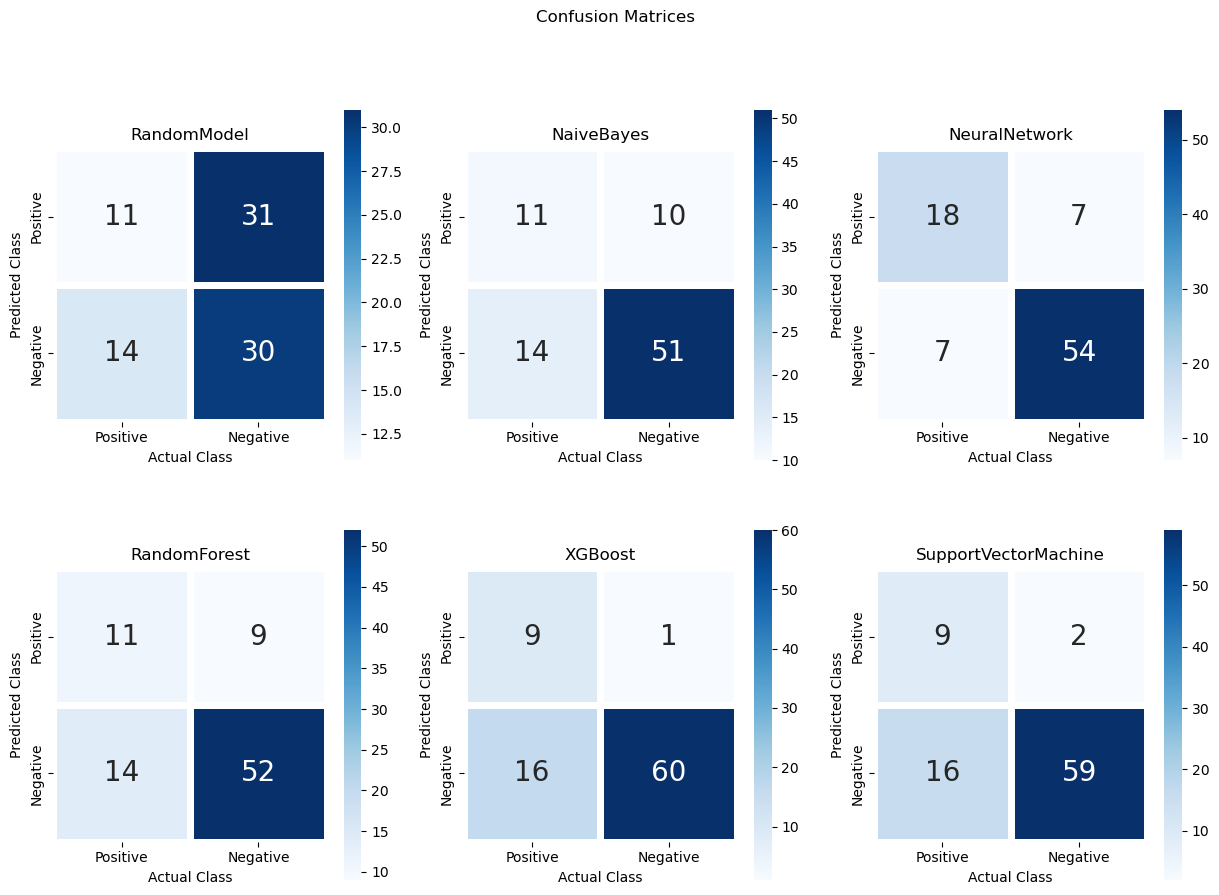

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [74]:
fig, axs = plt.subplots(2, ceil(len(models)/2))
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('Confusion Matrices')
for model_eval, ax in zip(model_evals.values(), axs.flatten()):
    model_eval.plot_confusion_matrix(ax)
plt.show()

In [75]:
results = pd.DataFrame(columns=['model', 'accuracy', 'recall(sensitvity)', 'specificity', 'precision', 'f1_score', 'support', 'auc'])

for name, model in model_evals.items():
    
    results = results.append({'model' : name,
                            'accuracy' : model.get_accuracy(), 
                            'recall(sensitvity)' : model.get_recall(), 
                            'specificity' : model.get_specificity(), 
                            'precision' : model.get_precision(), 
                            'f1_score' : model.get_f1_score(), 
                            'support' : model.get_support(), 
                            'auc' : model.get_auc(),
                            'execution time' : exec_times[name]}, 
                            ignore_index=True)
results


,model,accuracy,recall(sensitvity),specificity,precision,f1_score,support,auc,execution time
0,RandomModel,0.476744,0.44,0.491803,0.261905,0.328358,25,0.391803,0.000000
1,NaiveBayes,0.720930,0.44,0.836066,0.523810,0.478261,25,0.726885,0.003001
2,NeuralNetwork,0.837209,0.72,0.885246,0.720000,0.720000,25,0.849508,14.137046
3,RandomForest,0.732558,0.44,0.852459,0.550000,0.488889,25,0.672459,0.554088
4,XGBoost,0.802326,0.36,0.983607,0.900000,0.514286,25,0.822951,2.151674
5,SupportVectorMachine,0.790698,0.36,0.967213,0.818182,0.500000,25,0.694754,0.010015


W NN i XGBoost może wyjść zerowy execution time, jest tak gdyż korzystamy z pretrenowanych modeli

# ANALIZA ISTOTNOŚCI ATRYBUTÓW DLA SIECI NEURONOWYCH

### Wsp Shapleya

In [ ]:
import shap

===[ Model: RandomModel ]===


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


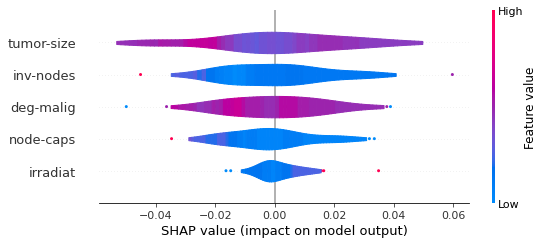

===[ Model: NaiveBayes ]===


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


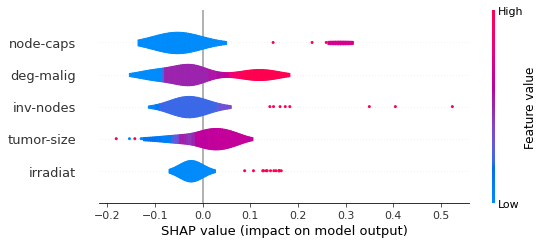

===[ Model: NeuralNetwork ]===


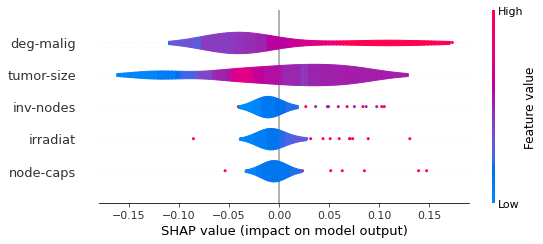

Exact explainer: 87it [00:12,  1.39it/s]                        
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


===[ Model: RandomForest ]===


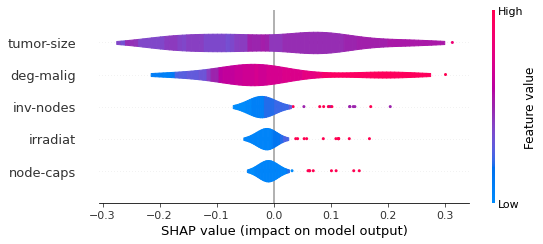

===[ Model: XGBoost ]===


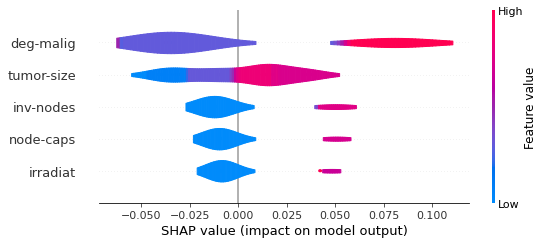

===[ Model: SupportVectorMachine ]===


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


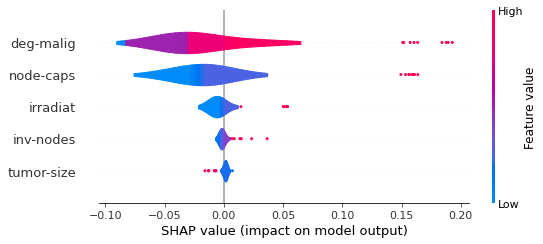

In [287]:
for name, model_eval in model_evals.items():
  model = model_eval.model
  # Fits the explainer
  explainer = shap.Explainer(model.predict, eval_x)
  # Calculates the SHAP values - It takes some time
  shap_values = explainer(eval_x)
  print(f"===[ Model: {name} ]===")
  shap.summary_plot(shap_values, plot_type='violin')

 ## Analiza wyników

### Wstępne założenia
W naszym zadaniu samo accuracy nie będzie dobrym wyznacznikiem jakości modelu. Ważne
będzie, aby przy ocenie wziąć pod uwagę Sensitivity oraz Specificty. To, aby ustalić która z
tych dwóch metryk jest ważniejsza, musi odpowiedzieć pytanie czy jesteśmy bardziej skłonni
dopuścić do klasyfikacji przypadków fałszywie negatywnych, czy fałszywie pozytywnych. Oso
biście zdaje mi się, że większe straty ponosimy w przypadku klasyfikacji FN, przypadki FP
zawsze można wykluczyć w dogłębnym badaniu, na przykład sięgając po opinię specjalistów
lub innego algorytmu. Dlatego zdaje mi się, że specificity będzie w tym problemie ważniej
szą metryką. Dodatkowo dobrymi miarami do porównania algorytmów będzie miara F1 oraz
krzywe ROC i AUC.

### !!! Pełna analiza w sprawozdaniu !!!
